In [17]:
# Cell 1: Import các thư viện cần thiết
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [18]:
# Cell 2: Cấu hình các tham số
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 4  # 0 trứng, 1 trứng, 2 trứng, 3 trứng

In [24]:
# Cell 3: Chuẩn bị data generator và kiểm tra cấu trúc dữ liệu
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator cho training data
train_generator = datagen.flow_from_directory(
    'Dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Generator cho validation data
validation_generator = datagen.flow_from_directory(
    'Dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Kiểm tra cấu trúc dữ liệu
print("Số lượng mẫu training:", train_generator.samples)
print("Số lượng mẫu validation:", validation_generator.samples)
print("Số lượng classes:", len(train_generator.class_indices))
print("Classes:", train_generator.class_indices)

Found 538 images belonging to 4 classes.
Found 132 images belonging to 4 classes.
Số lượng mẫu training: 538
Số lượng mẫu validation: 132
Số lượng classes: 4
Classes: {'0_trung': 0, '1_trung': 1, '2_trung': 2, '3-trung': 3}


In [25]:
# Cell 4: Xây dựng model
def build_model():
    # Base model
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Đóng băng các layer của base model
    base_model.trainable = False
    
    # Thêm các layer mới
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Tạo model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Tạo model
model = build_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,049,284 (11.63 MB)

 Trainable params: 789,764 (3.01 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [26]:
# Cell 5: Định nghĩa callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        'best_egg_detection_model.keras',  # Thay đổi đuôi file từ .h5 thành .keras
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

In [27]:
# Cell 6: Training model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.3313 - loss: 1.8806 - val_accuracy: 0.8788 - val_loss: 0.7872 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5992 - loss: 1.0537 - val_accuracy: 0.8409 - val_loss: 0.5914 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7828 - loss: 0.5323 - val_accuracy: 0.8485 - val_loss: 0.4841 - learning_rate: 1.0000e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8232 - loss: 0.5174 - val_accuracy: 0.8106 - val_loss: 0.4403 - learning_rate: 1.0000e-04
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8604 - loss: 0.3723 - val_accuracy: 0.8409 - val_loss: 0.4092 - learning_rate: 1.0000e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8633 - loss: 0.3239 - val_accuracy: 0.7727 - val_loss: 0.4114 - learning_rate: 1.0000e-04
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8863 - loss:

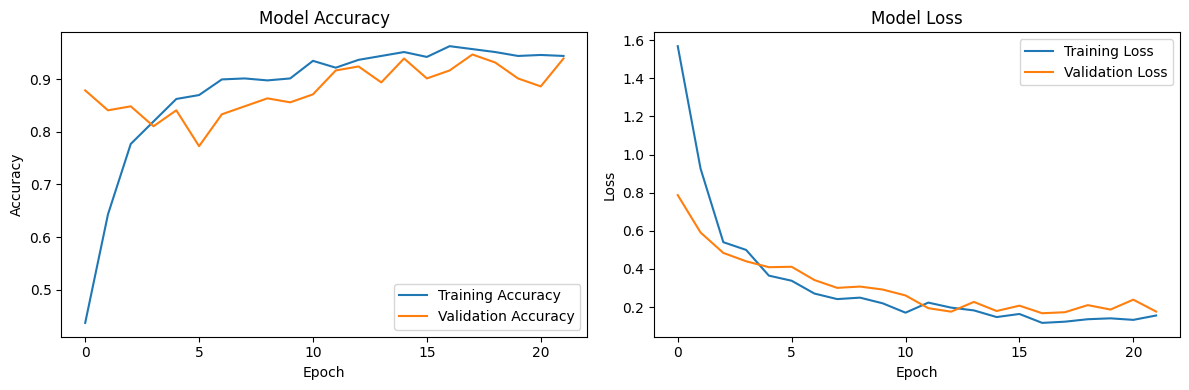

In [28]:
# Cell 7: Vẽ đồ thị kết quả training
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Cell 8: Hàm dự đoán cho ảnh mới
def predict_image(image_path):
    # Đọc và xử lý ảnh
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Dự đoán
    predictions = model.predict(img)[0]
    class_idx = np.argmax(predictions)
    confidence = predictions[class_idx]
    
    # Map kết quả
    classes = ['Không có trứng', '1 trứng', '2 trứng', '3 trứng']
    result = {
        'class': classes[class_idx],
        'confidence': float(confidence),
        'predictions': {classes[i]: float(pred) 
                      for i, pred in enumerate(predictions)}
    }
    
    return result

In [39]:
# Cell 9: Test model với một số ảnh
test_images = [
    './testcuoicung.jpg'  # Thay bằng đường dẫn thực tế đến ảnh test của bạn
    
]

# Kiểm tra tồn tại của file trước khi xử lý
import os
for img_path in test_images:
    if os.path.exists(img_path):
        result = predict_image(img_path)
        print(f"\nKết quả cho ảnh {img_path}:")
        print(f"Phân loại: {result['class']}")
        print(f"Độ tin cậy: {result['confidence']:.2f}")
        print("\nChi tiết dự đoán:")
        for class_name, prob in result['predictions'].items():
            print(f"{class_name}: {prob:.2f}")
    else:
        print(f"Không tìm thấy file ảnh: {img_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Kết quả cho ảnh ./testcuoicung.jpg:
Phân loại: 3 trứng
Độ tin cậy: 0.76

Chi tiết dự đoán:
Không có trứng: 0.00
1 trứng: 0.00
2 trứng: 0.24
3 trứng: 0.76


In [41]:
# Lưu model
model.save('egg_detection_model.h5')

# Lưu thông tin các class
import json
class_indices = train_generator.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)